# Sparse GP Regression

### 14th January 2014 James Hensman
#### 29th September 2014 Neil Lawrence (added sub-titles, notes and some references).

This example shows the variational compression effect of so-called 'sparse' Gaussian processes. In particular we show how using the variational free energy framework of [Titsias, 2009](http://jmlr.csail.mit.edu/proceedings/papers/v5/titsias09a/titsias09a.pdf) we can compress a Gaussian process fit. First we set up the notebook with a fixed random seed, and import GPy.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import GPy
import numpy as np
np.random.seed(101)

## Sample Function

Now we'll sample a Gaussian process regression problem directly from a Gaussian process prior. We'll use an exponentiated quadratic covariance function with a lengthscale and variance of 1 and sample 50 equally spaced points. 

In [2]:
N = 50
noise_var = 0.05

X = np.linspace(0,10,50)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

## Full Gaussian Process Fit

Now we use GPy to optimize the parameters of a Gaussian process given the sampled data. Here, there are no approximations, we simply fit the full Gaussian process.


Name : GP regression
Objective : 50.0860723468
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   1.65824860473  |      +ve      |        
  rbf.lengthscale          |   1.11215383162  |      +ve      |        
  Gaussian_noise.variance  |  0.236134236859  |      +ve      |        


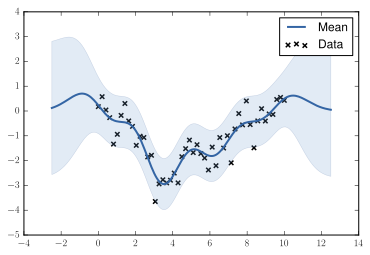

In [3]:
m_full = GPy.models.GPRegression(X,y)
m_full.optimize('bfgs')
m_full.plot()
print m_full

## A Poor `Sparse' GP Fit

Now we construct a sparse Gaussian process. This model uses the inducing variable approximation and initialises the inducing variables in two 'clumps'. Our initial fit uses the *correct* covariance function parameters, but a badly placed set of inducing points. 


Name : sparse gp
Objective : 260.809828016
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing inputs          |  (6, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.05  |      +ve      |        


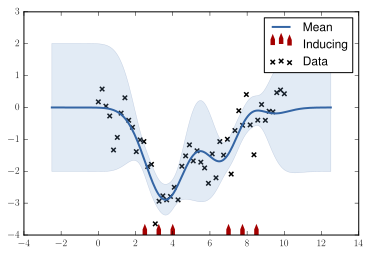

In [4]:
Z = np.hstack((np.linspace(2.5,4.,3),np.linspace(7,8.5,3)))[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.plot()
print m


Notice how the fit is reasonable where there are inducing points, but bad elsewhere. 

### Optimizing Covariance Parameters

Next, we will try and find the optimal covariance function parameters, given that the inducing inputs are held in their current location. 


Name : sparse gp
Objective : 53.9735537142
Number of Parameters : 9
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |           value  |  constraints  |  priors
  inducing inputs          |          (6, 1)  |     fixed     |        
  rbf.variance             |   1.73905117564  |      +ve      |        
  rbf.lengthscale          |   3.02312650701  |      +ve      |        
  Gaussian_noise.variance  |  0.372990010041  |      +ve      |        


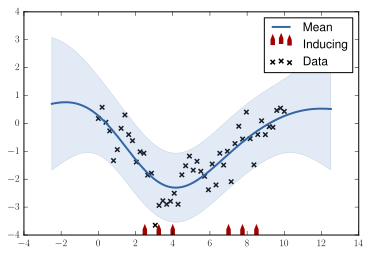

In [5]:
m.inducing_inputs.fix()
m.optimize('bfgs')
m.plot()
print m

The poor location of the inducing inputs causes the model to 'underfit' the data. The lengthscale is much longer than the full GP, and the noise variance is larger. This is because in this case the Kullback Leibler term in the objective free energy is dominating, and requires a larger lengthscale to improve the quality of the approximation. This is due to the poor location of the inducing inputs. 

### Optimizing Inducing Inputs

Firstly we try optimzing the location of the inducing inputs to fix the problem, however we still get a larger lengthscale than the Gaussian process we sampled from (or the full GP fit we did at the beginning).

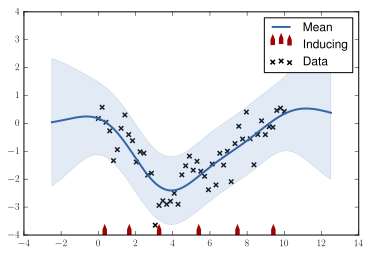

In [6]:
m.randomize()
m.Z.unconstrain()
m.optimize('bfgs')
m.plot()

The inducing points spread out to cover the data space, but the fit isn't quite there. We can try increasing the number of the inducing points.

### Train with More Inducing Points

Now we try 12 inducing points, rather than the original six. We then compare with the full Gaussian process likelihood.

[[-50.09844715]] -50.0860723468


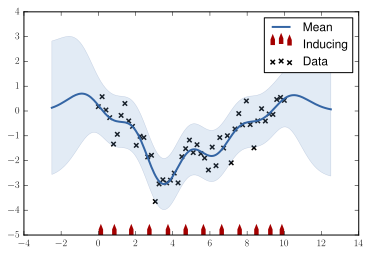

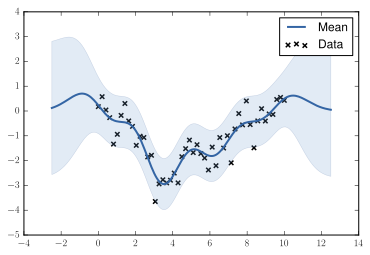

In [7]:
Z = np.random.rand(12,1)*12
m = GPy.models.SparseGPRegression(X,y,Z=Z)

m.optimize('bfgs')
m.plot()
m_full.plot()
print m.log_likelihood(), m_full.log_likelihood()

This time, we have enough inducing points and the fit resembles that of the GP. This is verified by the fact that the bound on the marginal likelihood is tight, which means that our variational approximation must be good (the difference between the bound and the true likelihood is the Kullback Leibler divergence between the approximation and the truth). 